In [37]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import cluster                
from skimage import measure
from sklearn import metrics
%matplotlib inline
def showbbox(classnum,target):
    imagergb = np.zeros([target.shape[0],target.shape[1],3],np.uint8)
    for i in xrange(3):
        imagergb[np.where(target!=0)[0],np.where(target!=0)[1],i]=255
        
    for i in xrange(1,classnum+1):
        if(np.where(target==i)[0].shape[0]==0):
            continue
        min0 = np.where(target==i)[0].min()
        max0 = np.where(target==i)[0].max()
        min1 = np.where(target==i)[1].min()
        max1 = np.where(target==i)[1].max()
        imagergb[min0:max0,min1,0]=255
        imagergb[min0:max0,max1,0]=255
        imagergb[min0,min1:max1,0]=255
        imagergb[max0,min1:max1,0]=255      
    
    plt.figure(figsize=(20,10))
    plt.imshow(imagergb)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def swt(source):
    result = cv2.distanceTransform(source,cv2.cv.CV_DIST_L2,5)
    minVal,maxVal,minLoc,maxLoc=cv2.minMaxLoc(result)
    strokeradius = np.uint8(np.ceil(maxVal))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    for i in xrange(strokeradius):
        result=cv2.dilate(result,kernel)
        result = np.multiply(result,source)
    
    return result

In [194]:
imag = cv2.imread("10.jpg",0)

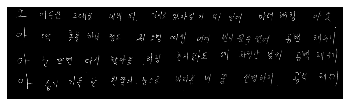

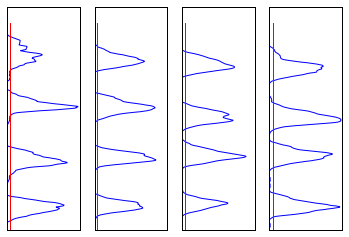

C:\Users\kiwoong\Anaconda2\lib\site-packages\ipykernel\__main__.py:103: RuntimeWarning: overflow encountered in ulong_scalars
C:\Users\kiwoong\Anaconda2\lib\site-packages\ipykernel\__main__.py:104: RuntimeWarning: overflow encountered in ulong_scalars


In [195]:
imag = cv2.resize(imag,(imag.shape[1]/2,imag.shape[0]/2),interpolation=cv2.INTER_CUBIC)
plt.imshow(imag,'gray')
imag = np.uint8(np.ones(imag.shape)*255-imag)
rows,cols= imag.shape
plt.imshow(imag,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

gaussian = cv2.adaptiveThreshold(np.uint8(np.ones(imag.shape)*255-imag),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
gaussian = np.ones(gaussian.shape)*255-gaussian

kernel = np.ones((5,5),np.uint8)
Gaussian_closing = cv2.morphologyEx(gaussian,cv2.MORPH_CLOSE,kernel)
binaryimg = np.uint8(Gaussian_closing/255)
imagesum = np.sum(binaryimg)/(float)(rows*cols)
stripwidth = 0
if(imagesum>=0.2):
    stripwidth = 0.05*cols
elif(imagesum>0.1):
    stripwidth = 0.1*cols
else:
    stripwidth = 0.25*cols

stripwidth = int(math.ceil(stripwidth))
proj = np.zeros([rows,(int)(math.ceil(cols/(float)(stripwidth)))])
rangemat = range(0,cols,stripwidth)
for i in xrange(0,cols/stripwidth):
    proj[:,i]=np.sum(Gaussian_closing[:,rangemat[i]:rangemat[i]+stripwidth-1],axis=1)    

if(cols%stripwidth!=0):    
    proj[:,-1] = np.uint(np.sum(Gaussian_closing[:,rangemat[i+1]:],axis=1))

proj2 = np.zeros([proj.shape[0]+9,proj.shape[1]])
proj2[4:-5,:]= proj
for i in range(rows):
    proj[i,:] = np.sum(proj2[i-4:i+5,:],axis=0)
    
proj = proj/9
x = range(proj.shape[0])
alpha = 5;

threshold = np.sum(proj,axis = 0)/(alpha*rows)


for i in xrange(len(rangemat)):
    plt.subplot(1,len(rangemat),i+1)
    plt.plot(proj[:,i],x)
    plt.plot(np.ones(proj[:,i].shape)*threshold[i],x,'r-')
    plt.xticks([])
    plt.yticks([])
plt.show()

AB = np.array([])
BB = np.array([])
ABConf = False
for j in range(rows):
    if(proj[j,0]>threshold[0] and proj[j-1,0]<=threshold[0]):
        AB = np.concatenate((AB,[j-2]))
        ABConf=True
    if((proj[j,0]>threshold[0] and proj[j+1,0]<=threshold[0])and(ABConf)):
        BB = np.concatenate((BB,[j+2]))
        ABConf = False

BBi = np.uint8(np.zeros(BB.shape))
ABi = np.uint8(np.ones(AB.shape)*rows)
        
for i in range(1,len(rangemat)):
    BBi = np.zeros(BBi.shape)
    ABi = np.ones(ABi.shape)*rows
    A_i = 0
    B_i = 0
    for j in range(rows):
        if(proj[j,i]>threshold[i] and proj[j-1,i]<=threshold[i]):
            ABi[A_i] = j-2
            A_i += 1
            ABConf=True
        if((proj[j,i]>threshold[i] and proj[j+1,i]<=threshold[i])and(ABConf)):
            BBi[B_i] = j+2
            B_i += 1
            ABConf = False
            
    AB = np.vstack((AB,ABi))
    BB = np.vstack((BB,BBi))

D = np.sum((np.abs(np.subtract(AB,BB))))/AB.nonzero()[0].shape[0]
#
#AB = AB.reshape([len(rangemat),AB.shape[0]/len(rangemat)])
#BB = BB.reshape([len(rangemat),BB.shape[0]/len(rangemat)])

minAB = np.uint(np.min(AB,axis=0))
maxBB = np.uint(np.max(BB,axis=0))
linenum = maxBB.shape[0]
rowmax = np.max(maxBB-minAB)

image_sep = np.uint8(np.zeros([linenum,rowmax,cols]))
image_sepb = np.uint8(np.zeros([linenum,rowmax,cols]))

AB = np.uint(AB)
BB = np.uint(BB)
for i in range(linenum):
    for j in range(len(rangemat)):
        image_sep[i,AB[j,i]-minAB[i]:BB[j,i]-minAB[i],rangemat[j]:rangemat[j]+stripwidth-1] = imag[AB[j,i]:BB[j,i],rangemat[j]:rangemat[j]+stripwidth-1]
        image_sepb[i,AB[j,i]-minAB[i]:BB[j,i]-minAB[i],rangemat[j]:rangemat[j]+stripwidth-1] =gaussian[AB[j,i]:BB[j,i],rangemat[j]:rangemat[j]+stripwidth-1]

In [217]:
pagenum = 3

In [218]:
target = image_sepb[pagenum,:,:]
target[target!=0] = 1
swt_image = swt(np.uint8(target))
AW = np.sum(swt_image)/np.sum(target)
target_c =  cv2.morphologyEx(target,cv2.MORPH_CLOSE,kernel)
y_proj = np.sum(target_c,axis=0)

y_proj2 = np.zeros([y_proj.shape[0]+5,])
cols = target.shape[0]
rows = target.shape[1]
y_proj2[2:-3] = y_proj
for i in range(rows):
    y_proj[i] = np.sum(y_proj2[i:i+5])/5 # smoothing projection

RB = 0
LB = 0
target[:,np.where(y_proj<round(AW))[0]] = 0
RowBoundary = np.where(y_proj<round(AW))[0]


# Show Image

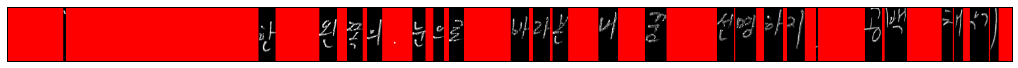

In [219]:
imageshow = np.zeros([target.shape[0],target.shape[1],3],np.uint8)
imageshow[:,:,0] = image_sep[pagenum,:,:]
imageshow[:,:,1] = image_sep[pagenum,:,:]
imageshow[:,:,2] = image_sep[pagenum,:,:]
imageshow[:,np.where(y_proj<round(AW))[0],0]=255
plt.figure(figsize=(18,6))
plt.imshow(imageshow)
plt.xticks([])
plt.yticks([])
plt.show()

In [220]:
componentlabel = 0
for i in xrange(1,len(RowBoundary)-1):
    if(RowBoundary[i]+1 != RowBoundary[i+1]):
        for j in xrange(i+1,len(RowBoundary)-1):
            if(RowBoundary[j]-1 != RowBoundary[j-1]):
                L = measure.label(target[:,RowBoundary[i]:RowBoundary[j]])
                L[L!=0] +=componentlabel
                curComMin = componentlabel
                curComMax = L.max()
                for i2 in xrange(curComMin+1,curComMax+1):
                    if(np.where(L==i2)[0].shape[0]<=10):
                        L[L==i2]=0
                    else:
                        componentlabel +=1
                        L[L==i2] = componentlabel
                    for k in xrange(i2+1, curComMax+1):
                        tempcomp2 = set(np.where(L==k)[1])
                        tempcomp =set(np.where(L==i2)[1])
                        if(len(tempcomp)*2./3 < len((tempcomp&tempcomp2))):  ## if projection area is overlapped more than 2/3, merege component
                            L[L==k]=componentlabel
                        elif(len(tempcomp2)*2./3 < len((tempcomp&tempcomp2))):
                            L[L==k]=componentlabel
                target[:,RowBoundary[i]:RowBoundary[j]]=L
                break
                

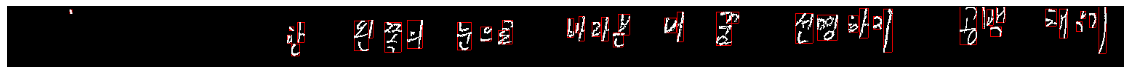

In [221]:
showbbox(componentlabel,target)

In [222]:
classnum = target.max()
gapdist= np.ones([classnum,3])*1000
for i in xrange(1,classnum+1):
    for j in xrange(1,classnum+1):
        if(j!=i):
            Xcenter = [[np.sum(np.where(target==i)[0])/np.where(target==i)[0].shape[0],np.sum(np.where(target==i)[1])/np.where(target==i)[0].shape[0]]]
            Ycenter = [[np.sum(np.where(target==j)[0])/np.where(target==j)[0].shape[0],np.sum(np.where(target==j)[1])/np.where(target==j)[0].shape[0]]]
            eucmetmin = metrics.pairwise.euclidean_distances(Xcenter,Ycenter).min()
            if(eucmetmin<gapdist[i-1,1]):
                gapdist[i-1,0] = j
                gapdist[i-1,1] = eucmetmin
                gapdist[i-1,2] = np.where(target==i)[0].shape[0] + np.where(target==j)[0].shape[0]

gapdist[:,1:2] = preprocessing.scale(gapdist[:,1:2])

model = cluster.AgglomerativeClustering()
pred=model.fit_predict(gapdist[:,1:])
componentlabel =0
checkingpred = np.ones(pred.shape,np.bool)
i = 0
L = np.zeros(target.shape,np.uint8)
withinchar = 0
while(np.sum(checkingpred)!=0):
    if(checkingpred[i]):
        if((pred[i]==withinchar)&(pred[(int)(gapdist[i,0]-1)]==withinchar)&(gapdist[(int)(gapdist[i,0]-1),0] == i+1)):
            componentlabel+=1
            L[target==i+1] = componentlabel
            L[target == gapdist[i,0]] = componentlabel  
            checkingpred[i] = False
            checkingpred[(int)(gapdist[i,0]-1)] = False
        else:
            componentlabel+=1
            L[target==i+1] = componentlabel
            checkingpred[i] = False
    i +=1

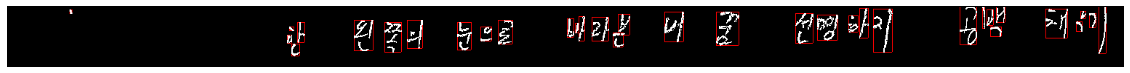

In [223]:
showbbox(componentlabel,L)

In [224]:
target = np.copy(L)
classnum = target.max()
gapdist= np.ones([classnum,3])*1000

for i in xrange(1,classnum+1):
    for j in xrange(1,classnum+1):
        if(j!=i):
            Xcenter = [[np.sum(np.where(target==i)[0])/np.where(target==i)[0].shape[0],np.sum(np.where(target==i)[1])/np.where(target==i)[0].shape[0]]]
            Ycenter = [[np.sum(np.where(target==j)[0])/np.where(target==j)[0].shape[0],np.sum(np.where(target==j)[1])/np.where(target==j)[0].shape[0]]]
            eucmetmin = metrics.pairwise.euclidean_distances(Xcenter,Ycenter).min()
            if(eucmetmin<gapdist[i-1,1]):
                gapdist[i-1,0] = j
                gapdist[i-1,1] = eucmetmin
                gapdist[i-1,2] = np.where(target==i)[0].shape[0] + np.where(target==j)[0].shape[0]

gapdist[:,1:2] = preprocessing.scale(gapdist[:,1:2])

pred=model.fit_predict(gapdist[:,1:])

componentlabel =0
checkingpred = np.ones(pred.shape,np.bool)
i = 0
L = np.zeros(target.shape,np.uint8)
withinchar = 0
while(np.sum(checkingpred)!=0):
    if(checkingpred[i]):
        if((pred[i]==withinchar)&(pred[(int)(gapdist[i,0]-1)]==withinchar)&(gapdist[(int)(gapdist[i,0]-1),0] == i+1)):
            componentlabel+=1
            L[target==i+1] = componentlabel
            L[target == gapdist[i,0]] = componentlabel  
            checkingpred[i] = False
            checkingpred[(int)(gapdist[i,0]-1)] = False
        else:
            componentlabel+=1
            L[target==i+1] = componentlabel
            checkingpred[i] = False
    i +=1

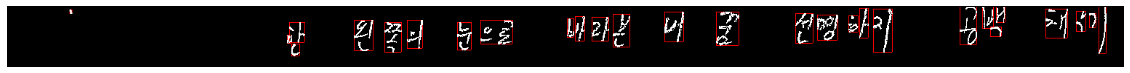

In [225]:
showbbox(componentlabel,L)

In [226]:
componentlabel

28

In [227]:
pred

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)